# Install package

In [1]:
# # install community
# library(devtools)

# devtools::install_github("SoloveyMaria/community")

# Calculate communication

In [2]:
# libraries
library(community)
# library(ggplot2)
library(data.table) #to read gz file
# library(gridExtra)
# library(grid)

In [3]:
input_dir <- "input_data/"
output_dir <- "computed_results/"

In [4]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /work/project/ladcol_011/conda_path/miniconda3/envs/community_tutorial2/lib/libopenblasp-r0.3.25.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=de_DE.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=de_DE.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=de_DE.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_DE.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] data.table_1.14.10 community_1.4.0   

loaded via a namespace (and not attached):
  [1] colorspace_2.1-0            rjson_0.2.21               
  [3] IRdisplay_1.1               htmlTable_2.4.2            
  [5] XVector_0.38.0              GenomicRanges_1.50.0 

## Load data

To calculate interactions, we will need the following files: normalized and batch corrected `counts`, cell annotation file `anno_cells`, and a sample annotation file `anno_samples`.

The `counts` file contains normalized and batch corrected counts with genes in the rows and cell IDs in the columns.

The `anno_cells` file should contain columns named cell_ID, cell_type and sample_ID.

The `anno_sample` file should countan columns named sample_ID health_status (e.g. "healthy" or "AML") and case_or_conrol (e.g. "control" or "case").

In [5]:
data("LR_database")

In [6]:
# data("LR_database")
print(str(LR_database))

'data.frame':	6941 obs. of  21 variables:
 $ True_LR              : logi  TRUE TRUE TRUE TRUE TRUE TRUE ...
 $ Pair.Name            : chr  "S100A10_TRPV6" "JAG2_NOTCH1" "DLL1_NOTCH1" "IGF1_IGF1R" ...
 $ Ligand               : chr  "S100A10" "JAG2" "DLL1" "IGF1" ...
 $ Ligand.Name          : chr  "S100 calcium binding protein A10" "jagged canonical Notch ligand 2" "delta like canonical Notch ligand 1" "insulin like growth factor 1" ...
 $ Receptor             : chr  "TRPV6" "NOTCH1" "NOTCH1" "IGF1R" ...
 $ Receptor.Name        : chr  "transient receptor potential cation channel subfamily V member 6" "notch receptor 1" "notch receptor 1" "insulin like growth factor 1 receptor" ...
 $ complex_pair         : chr  NA NA NA NA ...
 $ source               : chr  "P60903" "Q9Y219" "O00548" "P05019" ...
 $ target               : chr  "Q9H1D0" "P46531" "P46531" "P08069" ...
 $ is_directed          : num  1 1 1 1 1 1 1 1 1 1 ...
 $ is_stimulation       : num  1 1 1 1 1 1 1 1 1 1 ...
 $ is_inhibit

In [7]:
# # load counts
print("load counts")
counts <- fread(paste0(input_dir,"counts_corr.csv.gz"), header = TRUE)
counts <- as.data.frame(counts)
rownames(counts) <- counts$gene_symbol
counts <- counts[,-1]
print(str(counts))

[1] "load counts"
'data.frame':	12485 obs. of  74583 variables:
 $ AML1012-D0_AAAAAGTTACGT: num  0.05303 0.001436 -0.000537 0.003855 -0.012751 ...
 $ AML1012-D0_AAAACACCAATC: num  0.08409 0.00346 0.00616 -0.00104 0.0105 ...
 $ AML1012-D0_AAAATAGCCTTT: num  0.0296 0.00367 0.00277 0.0013 0.01117 ...
 $ AML1012-D0_AAACATTAAACG: num  0.17964 0.01121 0.00476 0.00064 0.0203 ...
 $ AML1012-D0_AAACCACGTGCN: num  1.03e-01 6.50e-04 1.32e-03 -3.60e-07 1.34e-03 ...
 $ AML1012-D0_AAACGCTGGAAN: num  0.08257 0.0019 0.00593 0.00202 0.01003 ...
 $ AML1012-D0_AAACTGGTACTA: num  0.05816 0.00433 -0.00118 0.00394 0.00348 ...
 $ AML1012-D0_AAACTTGCCCGT: num  0.115511 0.007234 0.001979 -0.000968 0.033918 ...
 $ AML1012-D0_AAATGAAAGTCC: num  0.04039 0.002127 0.001681 0.000654 0.005692 ...
 $ AML1012-D0_AAATGTACGGTA: num  0.05515 0.00234 0.00168 0.0021 -0.00182 ...
 $ AML1012-D0_AACAATGGTGTG: num  0.08485 0.001906 0.004815 -0.000146 0.019008 ...
 $ AML1012-D0_AACATTTAACAT: num  0.052289 0.003338 0.001932 0.000

In [8]:
# load cell annotation
print("load cell annotation")
anno_cells <- read.table(paste0(input_dir,"anno_cells_corr.txt")
                         ,sep = "\t"
                         ,row.names = 1
                         ,header = TRUE
                         )
print(str(anno_cells))

[1] "load cell annotation"
'data.frame':	74583 obs. of  37 variables:
 $ cell_ID.1                     : chr  "AML1012-D0_AAAAAGTTACGT" "AML1012-D0_AAAACACCAATC" "AML1012-D0_AAAATAGCCTTT" "AML1012-D0_AAACATTAAACG" ...
 $ cell_type_original            : chr  "GMP" "GMP-like" "Prog-like" "ProMono-like" ...
 $ sample_ID                     : chr  "AML1012-D0" "AML1012-D0" "AML1012-D0" "AML1012-D0" ...
 $ malignant                     : chr  "False" "True" "True" "True" ...
 $ patient_ID                    : chr  "AML1012" "AML1012" "AML1012" "AML1012" ...
 $ dataset                       : chr  "GSE116256" "GSE116256" "GSE116256" "GSE116256" ...
 $ gender                        : chr  "F" "F" "F" "F" ...
 $ age                           : int  32 32 32 32 32 32 32 32 32 32 ...
 $ health_status                 : chr  "AML" "AML" "AML" "AML" ...
 $ case_or_control               : chr  "case" "case" "case" "case" ...
 $ day                           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ cell_typ

In [9]:
# load sample annotation
print("load sample annotation")
anno_samples <- read.table(paste0(input_dir,"anno_samples_corr.txt")
                           ,sep = "\t"
                           ,row.names = 1
                           ,header = TRUE
                           )
print(str(anno_samples))

[1] "load sample annotation"
'data.frame':	33 obs. of  15 variables:
 $ sample_ID                    : chr  "AML1012-D0" "AML210A-D0" "AML328-D0" "AML419A-D0" ...
 $ patient_ID                   : chr  "AML1012" "AML210A" "AML328" "AML419A" ...
 $ dataset                      : chr  "GSE116256" "GSE116256" "GSE116256" "GSE116256" ...
 $ gender                       : chr  "F" "M" "F" "F" ...
 $ age                          : int  32 67 74 54 58 70 26 57 42 52 ...
 $ health_status                : chr  "AML" "AML" "AML" "AML" ...
 $ case_or_control              : chr  "case" "case" "case" "case" ...
 $ day                          : num  0 0 0 0 0 0 0 0 0 NA ...
 $ nr_cells_raw                 : int  1136 748 1094 1189 485 2328 1586 933 3813 108 ...
 $ nr_cells_cf                  : int  951 640 965 1091 399 2196 1410 869 3574 93 ...
 $ nr_cells_cf_ctf              : int  946 603 909 1086 388 2186 1407 868 3504 93 ...
 $ total_counts_raw_cf_ctf_gf   : int  2060373 1530216 2367765 278338

The ligand-receptor pair database is provided by the algorithm, but the user can also use a custom database. In this case, the custom database should have the columns named 'Ligand', 'Receptor' and 'Pair.Name'. 

In [10]:
colnames(counts) <- anno_cells$cell_ID
rownames(anno_cells) <- anno_cells$cell_ID

In our previous workflows, we defined a gene as expressed when it was detected in at least 10% of the cells in each cell type and sample. We will follow the same approach here, but instead of filtering out non-expressed genes, we will replace them with a value of 0.

## Thresholds

When calculation the interactions, it is possible to set three threshold: 
- `threshold_celltype_size` is a threshold for the minimum number of cells that a cell type should contain (in one sample). If the number of cells in the cell type of interest in a particular sample is less or equal to the `threshold_celltype_size`, then we consider this cell type as missing in this sample. This threshold affects the relative cell type abundance parameter (rho). The default value for the `threshold_celltype_size` is 4. 
- `threshold_nr_active_cells` is a threshold for the minimum number of active cells in a cell type (in the sample of interest). A cell is considered as active (for a specific gene), if it is expressing this gene above the `threshold_expr`. If the number of active cells (for a specific gene) in a cell type is smaller or equal to the `threshold_nr_active_cells`, i.e. does not pass the threshold, then it is set to zero (in this sample). This threshold affects the relative active fraction (phi) parameter. The default value for the `threshold_expr` is zero.
- `threshold_expr` is a threshold for an expression value of a gene in a cell. If an expression value af a gene in a cell is smaller or equal to the `threshold_expr` value, it will be set to zero. This threshold affects the relative active fraction (phi) and the relative mean expression (p) parameters. The default value for the `threshold_expr` is zero. In our analysis, we will set it arbitrarily to 0.05.

In [11]:
# set threshold of the cell type size
threshold_celltype_size <- 6
print("threshold_celltype_size >")
print(threshold_celltype_size)

[1] "threshold_celltype_size >"
[1] 6


In [12]:
# set threshold of the minimum number of active cells
threshold_nr_active_cells <- 6
print("threshold_nr_active_cells >")
print(threshold_nr_active_cells)

[1] "threshold_nr_active_cells >"
[1] 6


In [13]:
# set threshold of expression
threshold_expr <- 0.1
print("threshold_expr >")
print(threshold_expr)

[1] "threshold_expr >"
[1] 0.1


## Calculate interactions

In [14]:
# Renaming the cell_ID.1 column in anno_cells to "cell_ID"
# colnames(anno_cells)[colnames(anno_cells) == "cell_ID.1"] <- "cell_ID"

In [15]:
# colnames(anno_cells)[colnames(anno_cells) == "cell_ID"] <- "cell_IDXX"

In [16]:
print("calculate communication")
interactions = calculate_communication(counts = counts
                                       ,anno_samples = anno_samples
                                       ,anno_cells = anno_cells
                                       ,threshold_celltype_size = threshold_celltype_size
                                       ,threshold_nr_active_cells = threshold_nr_active_cells
                                       ,threshold_expr = threshold_expr
                                       ,lrp_database = LR_database
                                       )

# print(str(interactions))


[1] "calculate communication"


Warning message in e_cellType_gene(counts = counts_sub, anno_cells = anno_cells_sub, :
“WARNING: sample AML1012-D0 does not contain cell type B -- interactions for this cell type in this sample will get zero values.”
Warning message in e_cellType_gene(counts = counts_sub, anno_cells = anno_cells_sub, :
“WARNING: sample AML419A-D0 does not contain cell type T -- interactions for this cell type in this sample will get zero values.”
Warning message in e_cellType_gene(counts = counts_sub, anno_cells = anno_cells_sub, :
“WARNING: sample AML420B-D0 does not contain cell type DC -- interactions for this cell type in this sample will get zero values.”
Warning message in e_cellType_gene(counts = counts_sub, anno_cells = anno_cells_sub, :
“WARNING: sample AML916-D0 does not contain cell type Mono -- interactions for this cell type in this sample will get zero values.”
Warning message in e_cellType_gene(counts = counts_sub, anno_cells = anno_cells_sub, :
“WARNING: sample AML921A-D0 does not conta

## Calculate general statistics

The `general_stat` function calculates for each interaction several parameters that will be used for the QC, visualization and the differential communication analysis. 

Following parameters for the QC step will be stored in the `anno_interactions` list:
- mean expression of a ligand in the active fraction of the sending cell type within the control cohort (`mean_e_s_l_control`) and within the case cohort (`mean_e_s_l_case`). 
- mean  expression of a receptor in the active fraction of the receiving cell type within the control cohort (`mean_e_r_r_control`) and within the case cohort (`mean_e_r_r_case`).

Following parameters for the visualization will be stored in the `anno_interactions` list:
- log2 fold change of `rho_s` between the cases and the controls (`log2FC_rho_s`). It shows for each interaction, how the cell type abundance of the sending cell type changed in the cases compared to the controls.
- log2 fold change of `rho_r` between the cases and the controls (`log2FC_rho_r_r`). It shows for each interaction, how the cell type abundance of the receiving cell type changed in the cases compared to the controls.
- log2 fold change of `rho` between the cases and the controls (`log2FC_rho`). It shows for each interaction, how the whole `rho` parameter changed in the cases compared to the controls.
- log2 fold change of `phi_l_s` between the cases and the controls (`log2FC_phi_l_s`). It shows for each interaction, how the active fraction of the ligand in the sending cells changed in the cases compared to the controls.
- log2 fold change of `phi_r_r` between the cases and the controls (`log2FC_phi_r_r`). It shows for each interaction, how the active fraction of the receptors in the receiving cells changed in the cases compared to the controls.
- log2 fold change of `phi` between the cases and the controls (`log2FC_phi`). It shows for each interaction, how the whole `phi` parameter changed in the cases compared to the controls.
- log2 fold change of `p_l_s` between the cases and the controls (`log2FC_p_l_s`). It shows for each interaction, how the mean expression within the active fraction of the ligand in the sending cells changed in the cases compared to the controls.
- log2 fold change of `p_r_r` between the cases and the controls (`log2FC_p_r_r`). It shows for each interaction, how the mean expression within the active fraction of the receptor in the receiving cells changed in the cases compared to the controls.
- log2 fold change of `p` between the cases and the controls (`log2FC_p`). It shows for each interaction, how the whole `p` parameter changed in the cases compared to the controls.

Following parameter for the differential communication analysis will be stored in the `anno_interactions` list:
- log2 fold change of `weights` between the cases and the controls (`log2FC_weights`). It shows for each interaction, how the whole interaction weight changed in the cases compared to the controls.





In [17]:
print("calculate general statistics")

interactions <- general_stat(comm_result = interactions
                                   ,verbose = FALSE#TRUE
)
print(str(interactions$anno_interactions))

[1] "calculate general statistics"
'data.frame':	62064 obs. of  19 variables:
 $ interaction_ID     : chr  "HSPC:IGF1_HSPC:IGF1R" "HSPC:JAG1_HSPC:NOTCH1" "HSPC:IGF2_HSPC:IGF2R" "HSPC:FLT3LG_HSPC:FLT3" ...
 $ ligand_gene_name   : chr  "IGF1" "JAG1" "IGF2" "FLT3LG" ...
 $ receptor_gene_name : chr  "IGF1R" "NOTCH1" "IGF2R" "FLT3" ...
 $ sending_cell_type  : chr  "HSPC" "HSPC" "HSPC" "HSPC" ...
 $ receiving_cell_type: chr  "HSPC" "HSPC" "HSPC" "HSPC" ...
 $ mean_e_s_l_control : num  0 0 0 0.0281 0 ...
 $ mean_e_s_l_case    : num  0 0.037 0 0.0232 0 ...
 $ mean_e_r_r_control : num  0.0703 0 0.0332 0.5325 0.0703 ...
 $ mean_e_r_r_case    : num  0.0786 0.0121 0.0499 0.6494 0.0786 ...
 $ log2FC_rho_s       : num  3.22 3.22 3.22 3.22 3.22 ...
 $ log2FC_rho_r       : num  3.22 3.22 3.22 3.22 3.22 ...
 $ log2FC_rho         : num  5.73 5.73 5.73 5.73 5.73 ...
 $ log2FC_phi_s_l     : num  0 5.75 0 0 0 ...
 $ log2FC_phi_r_r     : num  0.57587 0 0 0.00686 0.57587 ...
 $ log2FC_phi         : num  0 0 

# QC

For the quality check, we use three filters: the **interaction weight filter**, the **presence per cohort filter** and the **ligand/receptor expression filter**. An interaction is considered of good quality, if it passes all three filters.

The **interaction weight filter** checks the log10 cumulative weight of the interaction. To pass this filter, the interaction needs to be greater than the `threshold_log10_cum_weight` threshold.

In [18]:
threshold_log10_cum_weight <-  0.01
print("threshold_log10_cum_weight >")
print(threshold_log10_cum_weight)

[1] "threshold_log10_cum_weight >"
[1] 0.01


The **presence per cohort filter** checks the fraction of samples in which an interaction was detected (i.e. has a non-zero value) in the control cohort and in the case cohort. To pass this filter, an interaction needs to have a greater value than the `threshold_frac_samples_per_condition` threshold either in the control cohort or in the case cohort or in both.

In [19]:
threshold_frac_samples_per_condition <-  0.6
print("threshold_frac_samples_per_condition >")
print(threshold_frac_samples_per_condition)

[1] "threshold_frac_samples_per_condition >"
[1] 0.6


The **ligand/receptor expression filter** checks the mean expression level of the ligand and the receptor of an interaction in the case and the control samples (separately). This filter uses a `threshold_log10meanexpr_per_condition` threshold.
For each interaction four values are checked:
- log10 mean expression of the ligand in sending cells in control samples
- log10 mean expression of the receptor in receiving cells in control samples
- log10 mean expression of the ligand in sending cells in case samples
- log10 mean expression of the receptor in receiving cells in case samples.


An interaction passes this filter if both its ligand and receptor pass the threshold either in control samples or in case samples or in both.

In [20]:
threshold_log10_meanexpr_per_condition <- 0.02
print("threshold_log10_meanexpr_per_condition >")
print(threshold_log10_meanexpr_per_condition)

[1] "threshold_log10_meanexpr_per_condition >"
[1] 0.02


A good quality interaction should pass all filters.

The `filter_interactions` function produces one plot for the **interaction weight filter**, two plots for the **presence per cohort filter** (one for the controls and one for the cases) and two plots for the **ligand/receptor expression filter** (one for the controls and one for the cases). It writes the selected threshold values in the `thresholds` list of the interaction object and stores the filtering results as boolean vectors (one per threshold) in the `anno_interactions` list. The function does not subset the data, so if you want to change the filtering parameters, you can re-define the thresholds and re-run the `filter_interactions` function.

[1] "filter weak interactions"


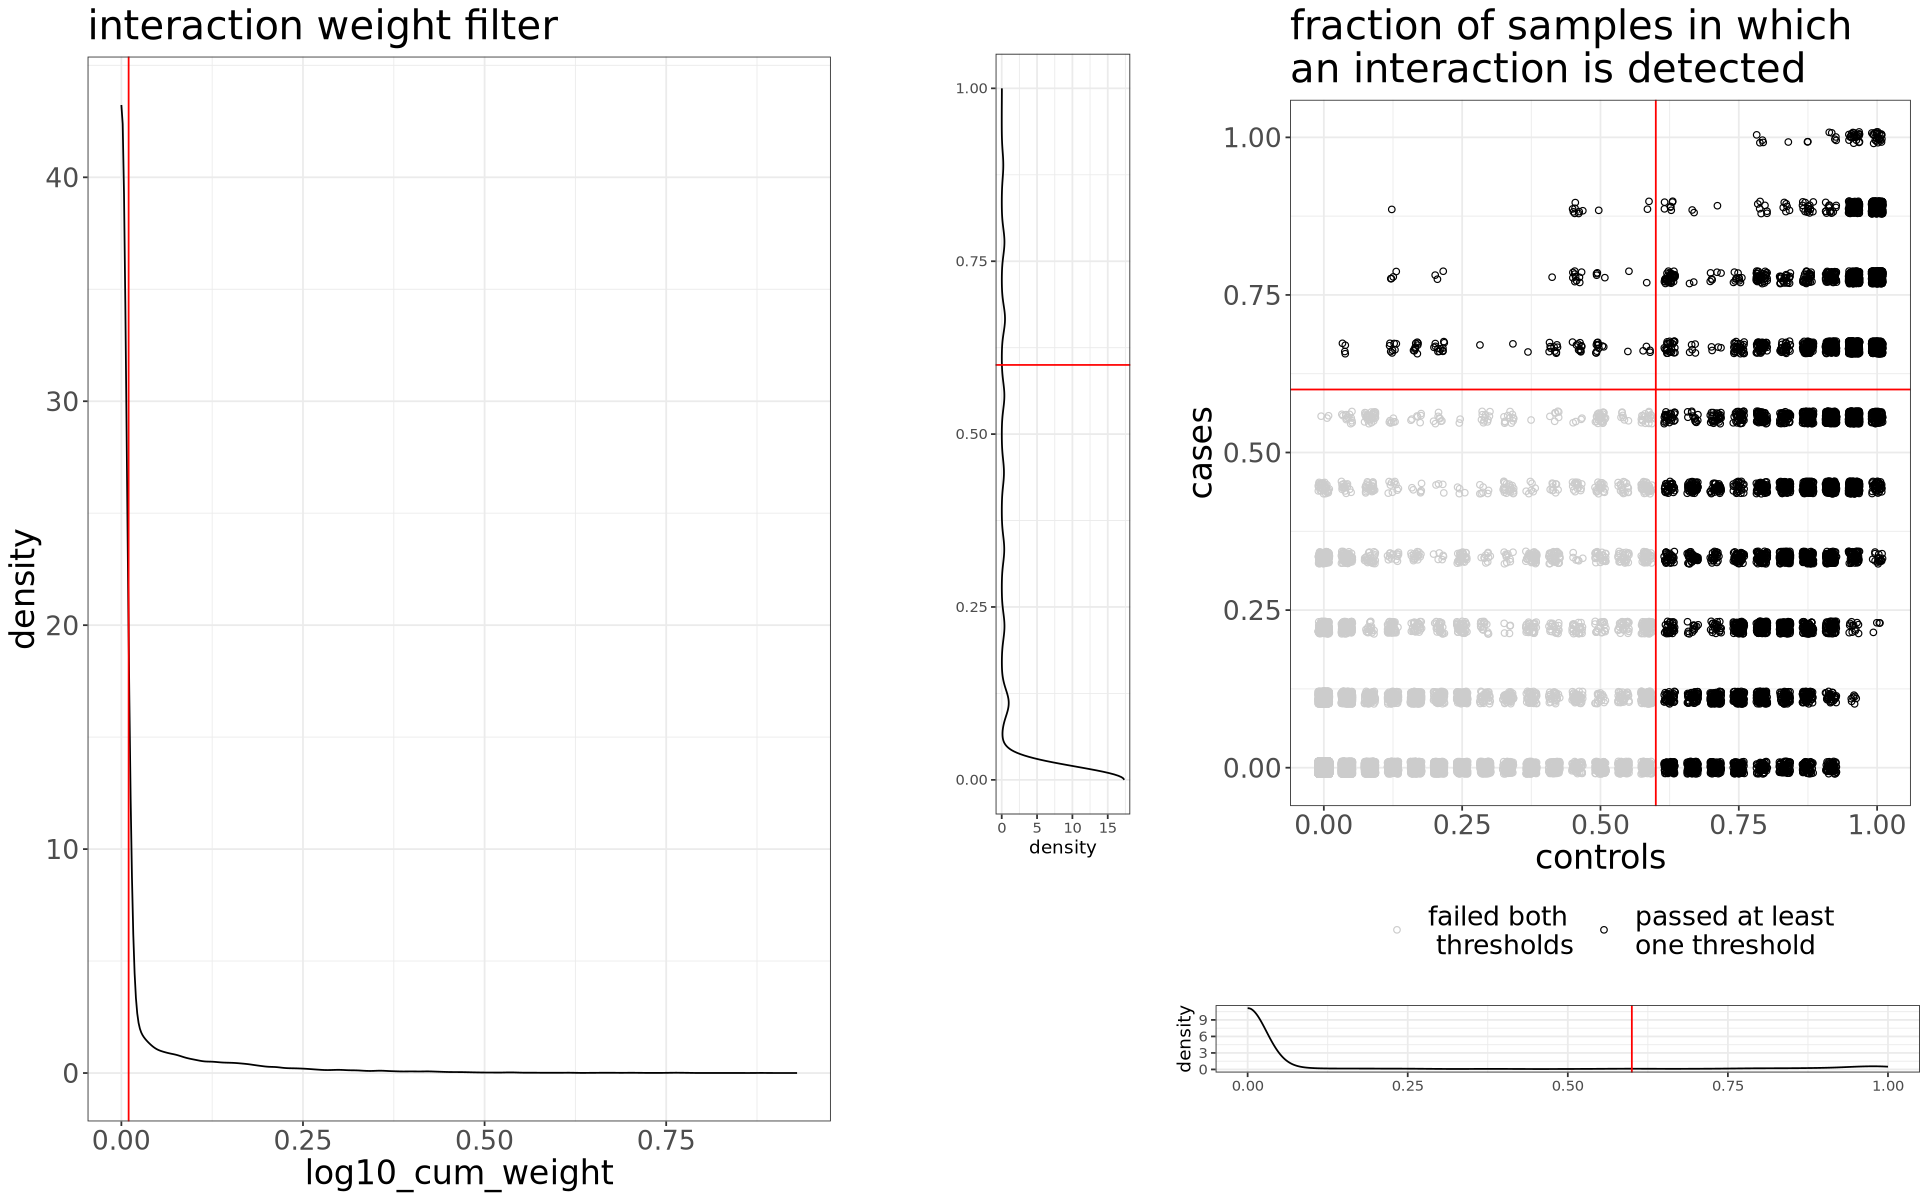

[1] "55021 out of 62064 interactions do not pass the thresholds for log10 cumulative interactions weight > 0.01 and fraction of expressing samples > 0.6 . Also  46883  interactions didn't pass the discrepancy filter.  In total, 55021  bad quality interactions will be removed and 7043 good quality interactions will remain."


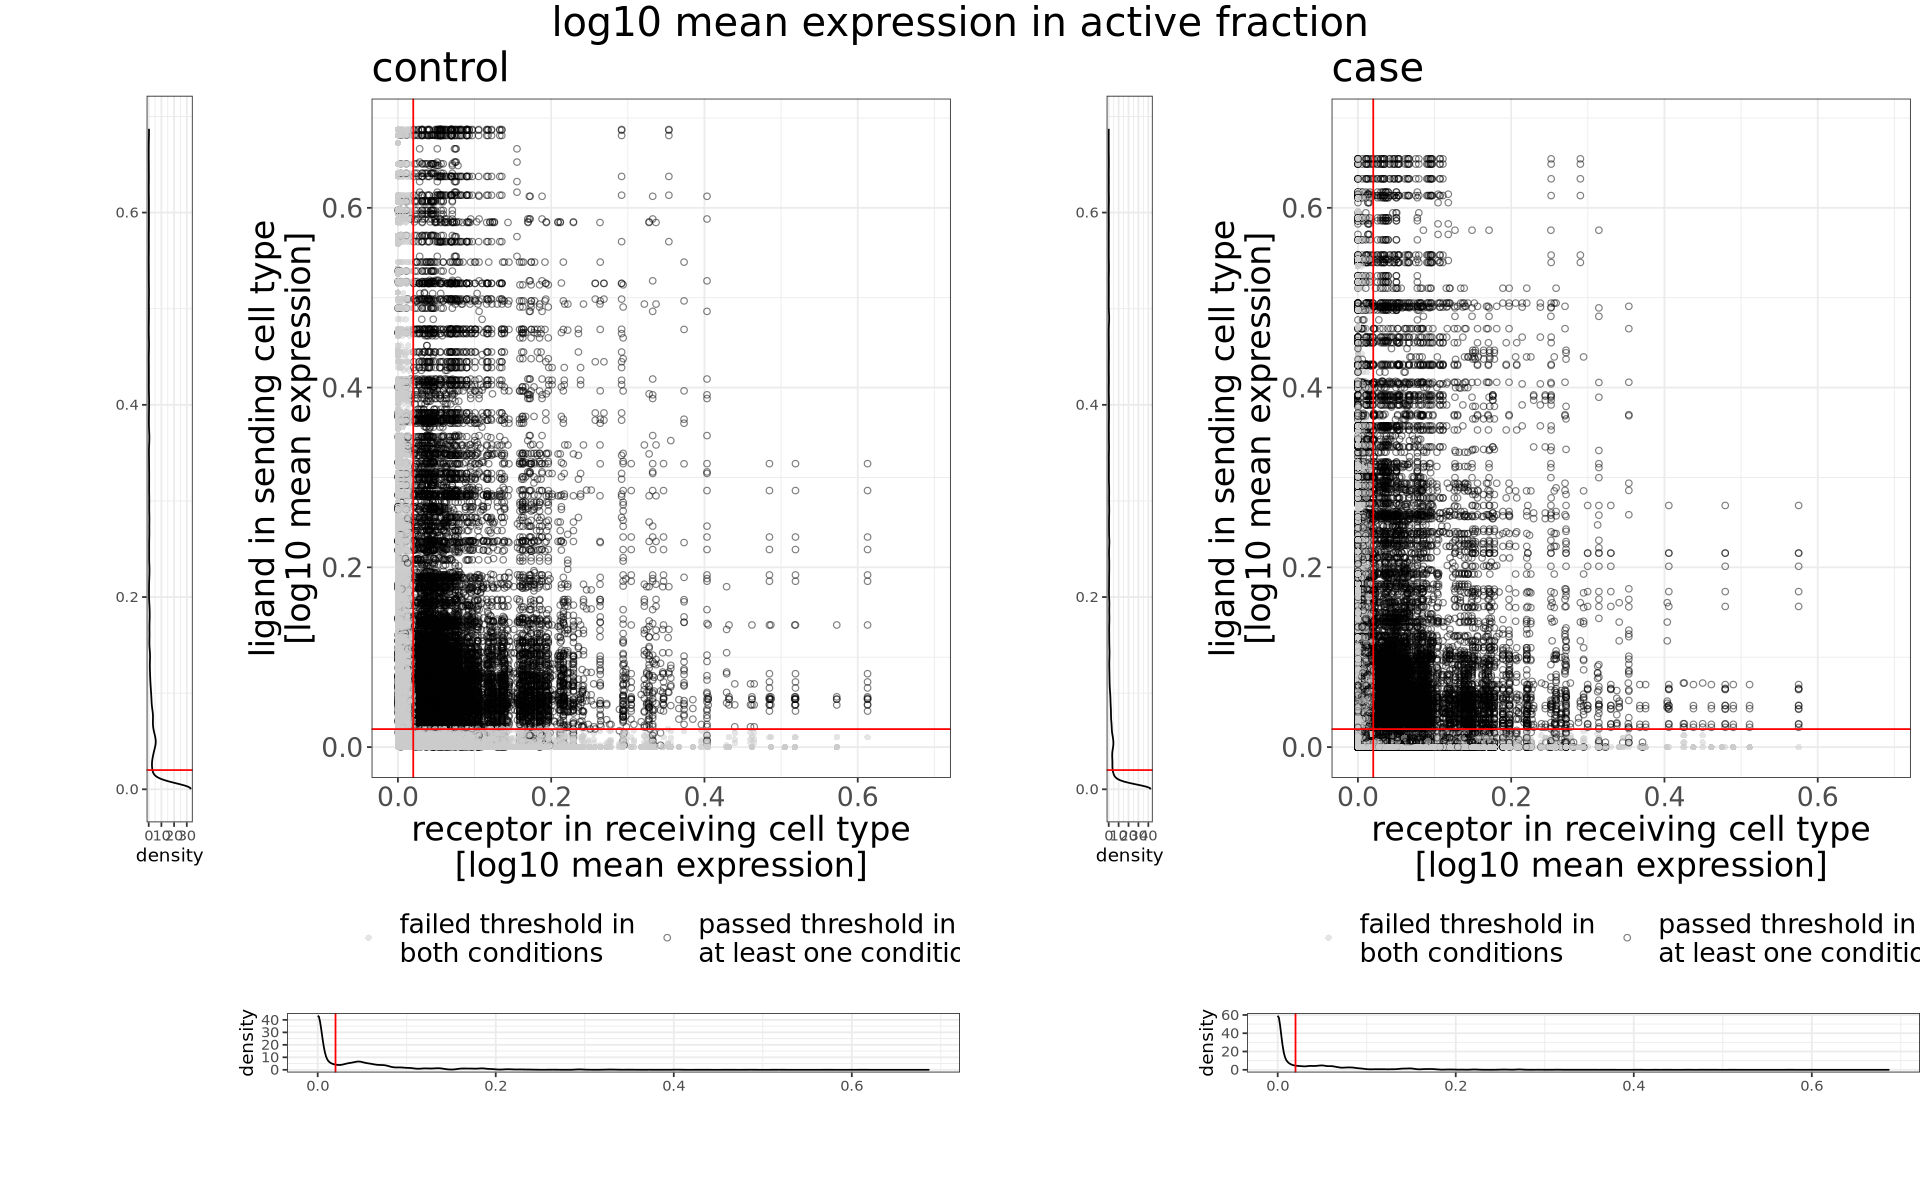

In [21]:
print("filter weak interactions")

options(repr.plot.height = 10
       ,repr.plot.width = 16)
interactions <- filter_interactions(comm_result = interactions
                             ,threshold_frac_samples_per_condition = threshold_frac_samples_per_condition
                             ,threshold_log10_cum_weight = threshold_log10_cum_weight
                             ,threshold_log10_meanexpr_per_condition = threshold_log10_meanexpr_per_condition
)

In [22]:
print(str(interactions$thresholds))
print(str(interactions$anno_interactions))

List of 6
 $ threshold_expr                        : num 0.1
 $ threshold_nr_active_cells             : num 6
 $ threshold_celltype_size               : num 6
 $ threshold_log10_cum_weight            : num 0.01
 $ threshold_frac_samples_per_condition  : num 0.6
 $ threshold_log10_meanexpr_per_condition: num 0.02
NULL
'data.frame':	62064 obs. of  28 variables:
 $ interaction_ID                            : chr  "HSPC:IGF1_HSPC:IGF1R" "HSPC:JAG1_HSPC:NOTCH1" "HSPC:IGF2_HSPC:IGF2R" "HSPC:FLT3LG_HSPC:FLT3" ...
 $ ligand_gene_name                          : chr  "IGF1" "JAG1" "IGF2" "FLT3LG" ...
 $ receptor_gene_name                        : chr  "IGF1R" "NOTCH1" "IGF2R" "FLT3" ...
 $ sending_cell_type                         : chr  "HSPC" "HSPC" "HSPC" "HSPC" ...
 $ receiving_cell_type                       : chr  "HSPC" "HSPC" "HSPC" "HSPC" ...
 $ mean_e_s_l_control                        : num  0 0 0 0.0281 0 ...
 $ mean_e_s_l_case                           : num  0 0.037 0 0.0232 0 ...


# Differential Communication

For calculating statistically significant differential interactions between the cases and the controls, we need to define an adjusted p-value threshold and the log2 fold change threshold. 

In [23]:
# Set up log2 fold change threshold. The default value is 1
threshold_log2FC <- 1
print(paste("[absolute] threshold_log2FC >",threshold_log2FC))

[1] "[absolute] threshold_log2FC > 1"


In [24]:
# Set up FDR threshold. The default value is 0.1
threshold_fdr <- 0.1
print(paste("threshold_fdr <",threshold_fdr))

[1] "threshold_fdr < 0.1"


The `test_diff` function stores the thresholds in the `thresholds` list of the interactions object.

The `test_diff` function calculates a p-value for each interaction using a Wilcoxon test and adjusts for multiple testing using the FDR correction method. After that, the function checks whether the log2 fold change and the adjusted p-value thresholds were passed. An interaction is considered significant if it passes both thresholds. The `test_diff` function stores the results as a boolean vector to the `anno_interactions` list of the interactions object.

In [25]:
print("calculate differential communication")
interactions <- test_diff(comm_result = interactions
                          ,threshold_fdr = threshold_fdr
                          ,which_test = "t-test"
                          ,threshold_log2FC = threshold_log2FC
                          
                         )
print(str(interactions$thresholds))
print(str(interactions$anno_interactions))

[1] "calculate differential communication"
[1] "We have 3509 dignificantly differential interactions"
List of 8
 $ threshold_expr                        : num 0.1
 $ threshold_nr_active_cells             : num 6
 $ threshold_celltype_size               : num 6
 $ threshold_log10_cum_weight            : num 0.01
 $ threshold_frac_samples_per_condition  : num 0.6
 $ threshold_log10_meanexpr_per_condition: num 0.02
 $ threshold_fdr                         : num 0.1
 $ threshold_log2FC                      : num 1
NULL
'data.frame':	62064 obs. of  33 variables:
 $ interaction_ID                            : chr  "HSPC:IGF1_HSPC:IGF1R" "HSPC:JAG1_HSPC:NOTCH1" "HSPC:IGF2_HSPC:IGF2R" "HSPC:FLT3LG_HSPC:FLT3" ...
 $ ligand_gene_name                          : chr  "IGF1" "JAG1" "IGF2" "FLT3LG" ...
 $ receptor_gene_name                        : chr  "IGF1R" "NOTCH1" "IGF2R" "FLT3" ...
 $ sending_cell_type                         : chr  "HSPC" "HSPC" "HSPC" "HSPC" ...
 $ receiving_cell_type      

# Interplay of individual components

<img src="../components_scheme.png">

We defined six components that influence the behavior of each interaction:
- rho_s
- phi_s_l
- p_s_l
- rho_r
- phi_r_r
- p_r_r

Each of these components can be changing independently in different directions. Based on the log2FC of each of them, we will define their direction:

**Direction of the log2FC per component**:
- *log2FC_rho_s_direction
- *log2FC_phi_s_l_direction
- *log2FC_p_s_l_direction
- *log2FC_rho_r_direction
- *log2FC_phi_r_r_direction
- *log2FC_p_r_r_direction -- can have values:
    - 0 -- if the absolute log2FC is less than the threshold_log2FC_component, i.e. unchanged
    - 1 -- if the log2FC is greater than the threshold_log2FC_component, i.e. upregulated
    - -1 -- if the log2FC is less than minus threshold_log2FC_component, i.e. downregulated

Depending on how they interplay, we will split them into groups showing different characteristics.

First, it is important for us to know whether the components of only one of the two interacting partners are affected (either the sender or the receiver), or of both of them. To know this, we will calculate how many components were affected for each interacting partners:

**List of affected components per interacting partner**
- *components_affected_s* -- (sender) can have values:
- *components_affected_r* -- (receiver) can have values:
    - none
    - p
    - phi
    - rho
    - phi_p
    - rho_p
    - rho_phi
    - rho_phi_p

**Number of components affected per interacting partner**:
- *nr_comp_affected_s* -- (sender) can have values: 
    - 0, 1, 2, or 3
- *nr_comp_affected_r* -- (receiver) can have values: 
    - 0, 1, 2, or 3
- *nr_comp_affected_b* -- (both) can have values: 
    - 0, 1, 2, 3, 4, 5, or 6
    
**Which counterpart is affected**:
- *sender_or_receiver_affected* can have values:
    - none -- if nr component sender is = 0 and nr component receiver is = 0
    - sender -- if nr component sender is > 0 and nr component receiver is = 0
    - receiver -- if nr component sender is = 0 and nr component receiver is > 0
    - both -- if nr component sender is > 0 and nr component receiver is > 0
    
**Direction of the affected components per interacting partner**
- *direction_s* -- (sender) can have values:
- *direction_r* -- (receiver) can have values:
- *direction_b* -- (both) can have values:
    - none -- if zero components affected
    - up -- if >0 components affected in the same direction (upregulated)
    - down -- if >0 components affected in the same direction (downregulated)
    - both -- if >1 components affected in the opposite direction
    
If several components are affected, it is important to see, if the direction of the change is the same, such that the overall change is concordant, or it is opposite, such that the overall change is discordant.

**Concordance of direction of affected components per interacting partner**
- *concordance_s* -- (sender) can have values:
- *concordance_r* -- (receiver) can have values:
    - undefined -- if zero or one component is affected, i.e. not enough components to talk about concordance
    - concordant -- if several components are affected in the same direction
    - discordant -- if several components are affected in opposite directions
- *concordance_b* -- (both) can have values:
    - undefined -- if zero or one component is affected, i.e. not enough components to talk about concordance
    - concordant -- if several components are affected in the same direction
    - discordant -- if:
         - both concordance_s and concordance_r have one component changed each, but their direction is opposite
         - both concordance_s and concordance_r have several components changed each are both concordant, but their direction is opposite
         - either concordance_s or concordance_r is discordant while the other one is concordant
         - both concordance_s and concordance_r are discordant

**Interaction category**
 - *no_change* -- if log2FC of the interaction weight is did not pass the threshold_log2FC and none of the components is affected
    
 - *simple_decrease* -- if log2FC of the interaction weight is less than minus threshold_log2FC and only one of the components is affected and is downregulated
     
 - *simple_increase* -- if log2FC of the interaction weight is greater than the threshold_log2FC and only one of the components is affected and is upregulated
     
 - *concordant_decrease* -- if log2FC of the interaction weight is less than minus threshold_log2FC, several components are affected and all of them are downregulated
    
 - *concordant_increase* -- if log2FC of the interaction weight is greater than the threshold_log2FC, several components are affected and all of them are upregulated
    
 - *insufficient_compensation* -- if log2FC of the interaction weight is passed the threshold_log2FC in either direction and several components are affected disconcordantly
    
 - *sufficient_compensation* -- if log2FC of the interaction weight is did not pass the threshold_log2FC and several components are affected disconcordantly


In [26]:
# calculate interactions of the individual components
interactions <- interaction_classes(interactions
                   ,threshold = threshold_log2FC)
print(str(interactions$anno_interactions))

'data.frame':	62064 obs. of  52 variables:
 $ interaction_ID                            : chr  "HSPC:IGF1_HSPC:IGF1R" "HSPC:JAG1_HSPC:NOTCH1" "HSPC:IGF2_HSPC:IGF2R" "HSPC:FLT3LG_HSPC:FLT3" ...
 $ ligand_gene_name                          : chr  "IGF1" "JAG1" "IGF2" "FLT3LG" ...
 $ receptor_gene_name                        : chr  "IGF1R" "NOTCH1" "IGF2R" "FLT3" ...
 $ sending_cell_type                         : chr  "HSPC" "HSPC" "HSPC" "HSPC" ...
 $ receiving_cell_type                       : chr  "HSPC" "HSPC" "HSPC" "HSPC" ...
 $ mean_e_s_l_control                        : num  0 0 0 0.0281 0 ...
 $ mean_e_s_l_case                           : num  0 0.037 0 0.0232 0 ...
 $ mean_e_r_r_control                        : num  0.0703 0 0.0332 0.5325 0.0703 ...
 $ mean_e_r_r_case                           : num  0.0786 0.0121 0.0499 0.6494 0.0786 ...
 $ log2FC_rho_s                              : num  3.22 3.22 3.22 3.22 3.22 ...
 $ log2FC_rho_r                              : num  3.22 3.22

In [26]:
# load("interactions.RData")

In [27]:
write.csv(interactions$weights,paste0(output_dir,"community_weights.csv"))

In [28]:
write.csv(interactions$anno_interactions,paste0(output_dir,"community_anno_interactions.csv"))

In [29]:
print("save interactions.RData")
save(interactions, file = paste0(output_dir,"interactions.RData"))

[1] "save interactions.RData"
